---
# Source2Suffering Notebook
---

**Author** : Amaury Laridon

**Date** : 10/06/2025

**Content** : Notebook used for development of the pipelines needed for the Laridon et al.(2025) publication. 

---

Init Libraries and Path

In [17]:
#%%  ----------------------------------------------------------------
# import and path
# ----------------------------------------------------------------

import xarray as xr
import pickle as pk
import time
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import mapclassify as mc
from copy import deepcopy as cp
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy as cr
import geopandas as gpd
import sys
from operator import index
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import stats as sts
import regionmask as rm
import glob
%matplotlib inline

notebook_path = os.getcwd()  # Current path
print("Directory of the notebook:", notebook_path)
notebook_path = notebook_path

scripts_dir = "/data/brussel/vo/000/bvo00012/vsc11137/source2suffering"
data_dir = scripts_dir+"/data/"

sys.path.append(os.path.abspath(scripts_dir))

Directory of the notebook: /vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc11137/source2suffering/notebooks


Settings

In [18]:
ages = np.arange(60,-1,-1)
age_young = 0
age_ref = np.nanmax(ages)
age_range = np.arange(0,105)
year_ref = 2020
year_start = year_ref - age_ref
birth_years = np.arange(year_start,year_ref+1)     
year_end = 2113 # based on maximum life expectancy reported in UNWPP
year_range = np.arange(year_start,year_end+1)
# Definition of the hazards 
hazards = [
    "burntarea",
    "cropfailedarea",
    "driedarea",
    "floodedarea",
    "heatwavedarea",
    "tropicalcyclonedarea"
]
hazards_name = [
    "Wildfires",
    "Crop Failures",
    "Droughts",
    "River Floods",
    "Heatwaves",
    "Tropical Cyclones"
]

## 1. Reference Pulse of 1 GtCO2eq

In [19]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_World_gmt_{}_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm'), 'rb') as f:
        ds_S2S_Reference_Pulse_gmt_ar6_new_rm = pk.load(f)

print(ds_S2S_Reference_Pulse_gmt_ar6_new_rm)

<xarray.Dataset>
Dimensions:                                                         (hazard: 6,
                                                                     birth_year: 22)
Coordinates:
  * hazard                                                          (hazard) <U20 ...
  * birth_year                                                      (birth_year) int64 ...
Data variables:
    valc_nr_children_facing_extra_hazard_Reference_Pulse            (hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse      (hazard) float64 ...
    valc_slope_exposure                                             (hazard, birth_year) float64 ...
    valc_nr_children_facing_extra_hazard_Reference_Pulse_ref        (hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref  (hazard) float64 ...
    valc_slope_exposure_ref                                         (hazard, birth_year) float64 ...


### 1.1 Total number of the people exposed to an additional hazard

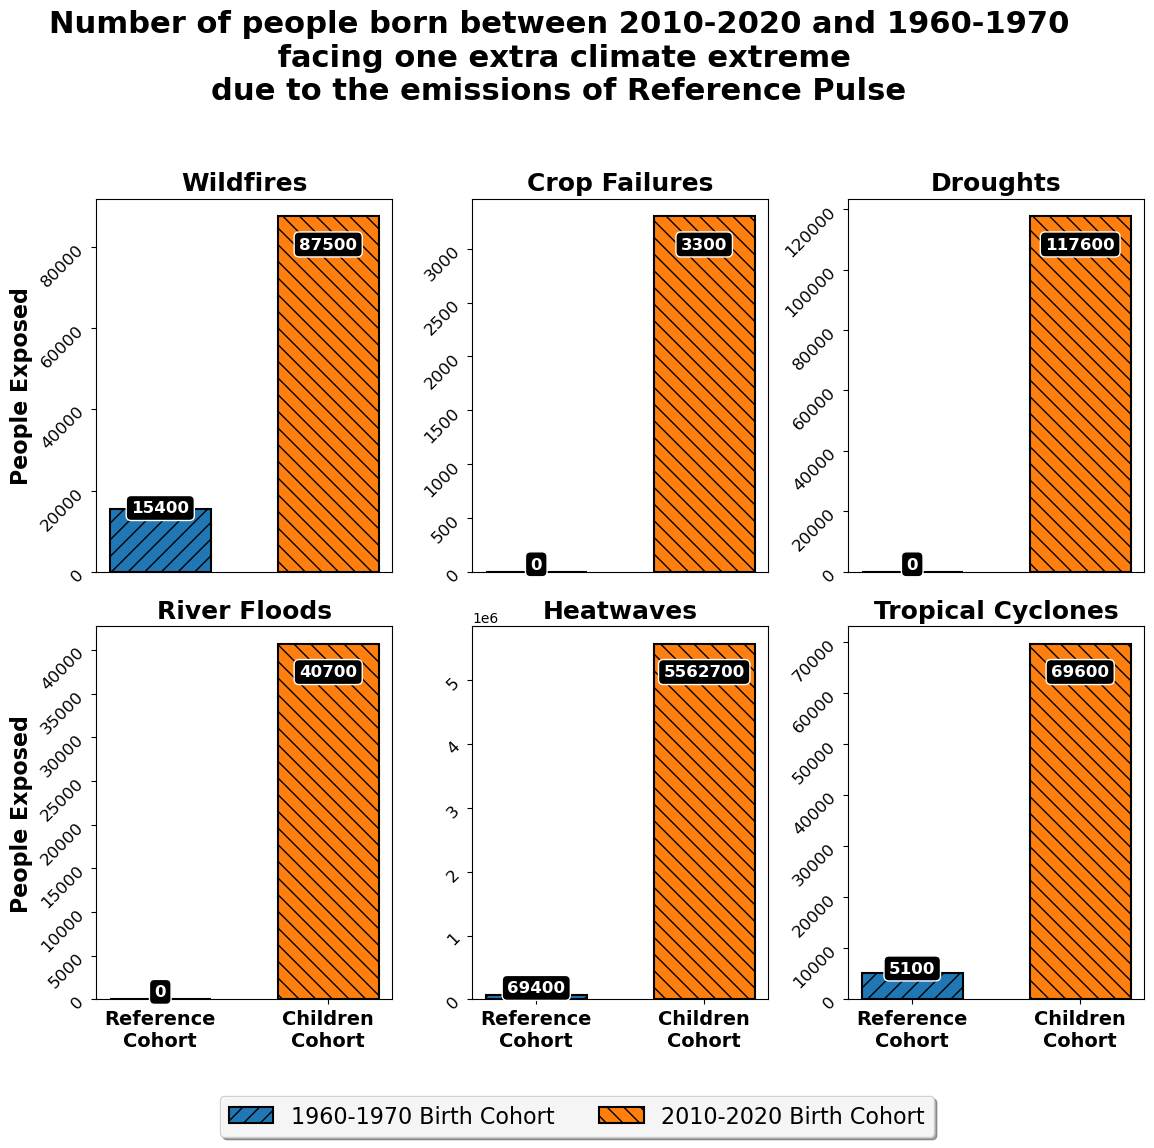

In [20]:
plt.close('all')

# Get data from the dataset
hazards = ds_S2S_Reference_Pulse_gmt_ar6_new_rm[
    'valc_total_nr_children_facing_extra_hazard_Reference_Pulse'
].coords['hazard'].values

values_s2s_ref = ds_S2S_Reference_Pulse_gmt_ar6_new_rm[
    'valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref'
].values

values_s2s = ds_S2S_Reference_Pulse_gmt_ar6_new_rm[
    'valc_total_nr_children_facing_extra_hazard_Reference_Pulse'
].values

n = len(hazards)

order_indices = [np.where(hazards == h)[0][0] for h in hazards]
values_s2s_ref = values_s2s_ref[order_indices]
values_s2s = values_s2s[order_indices]
#hazards = np.array(hazards)

fig, axs = plt.subplots(2, 3, figsize=(12, 12), sharey=False)

axs = axs.flatten()

for i in range(n):
    ax = axs[i]

    bar_ref = ax.bar(0, values_s2s_ref[i], width=0.6, color='tab:blue', hatch='//',
                     label='1960-1970 Birth Cohort', edgecolor='black', linewidth=1.5)
    bar_s2s = ax.bar(1, values_s2s[i], width=0.6, color='tab:orange', hatch='\\\\',
                     label='2010-2020 Birth Cohort', edgecolor='black', linewidth=1.5)

    ax.set_title(hazards_name[i], fontsize=18, fontweight='bold')

    if i % 3 == 0:
        ax.set_ylabel('People Exposed', fontsize=16, fontweight='bold')

    if i // 3 == 1:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Reference\nCohort', 'Children\nCohort'], fontsize=14, fontweight='bold')
    else:
        ax.set_xticks([])

    ax.tick_params(axis='y', labelsize=12, rotation=45)

    if not np.isnan(values_s2s_ref[i]):
        ax.text(0, values_s2s_ref[i] * 0.90, f'{int(np.round(values_s2s_ref[i]))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))
    if not np.isnan(values_s2s[i]):
        ax.text(1, values_s2s[i] * 0.90, f'{int(np.round(values_s2s[i]))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

fig.suptitle(
    "Number of people born between 2010-2020 and 1960-1970\n facing one extra climate extreme\n"
    "due to the emissions of Reference Pulse",
    fontsize=22, fontweight='bold', y=0.95
)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=16, frameon=True, framealpha=0.9, fancybox=True, shadow=True)

plt.tight_layout(rect=[0.03, 0.07, 1, 0.92])
plt.savefig(scripts_dir + '/figures/source2suffering/reference_pulse/fig1_Reference_Pulse_valc_total.png',bbox_inches='tight',dpi=300)
plt.show()


## 2. Spatialization of the exposure

### 2.1 Spatialization at the regional level

#### Total number of people exposed per region

##### A. 21 years Rolling Mean Configuration

In [ ]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_Regions_gmt_{}_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm'), 'rb') as f:
        ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm = pk.load(f)

<xarray.Dataset>
Dimensions:                                                         (hazard: 6,
                                                                     birth_year: 22)
Coordinates:
  * hazard                                                          (hazard) <U20 ...
  * birth_year                                                      (birth_year) int64 ...
    region                                                          <U13 'Nor...
Data variables:
    valc_nr_children_facing_extra_hazard_Reference_Pulse            (hazard, birth_year) float64 ...
    valc_nr_children_facing_extra_hazard_Reference_Pulse_ref        (hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse      (hazard) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref  (hazard) float64 ...
    valc_slope_exposure                                             (hazard, birth_year) float64 ...
    valc_slope_exposure_ref                       

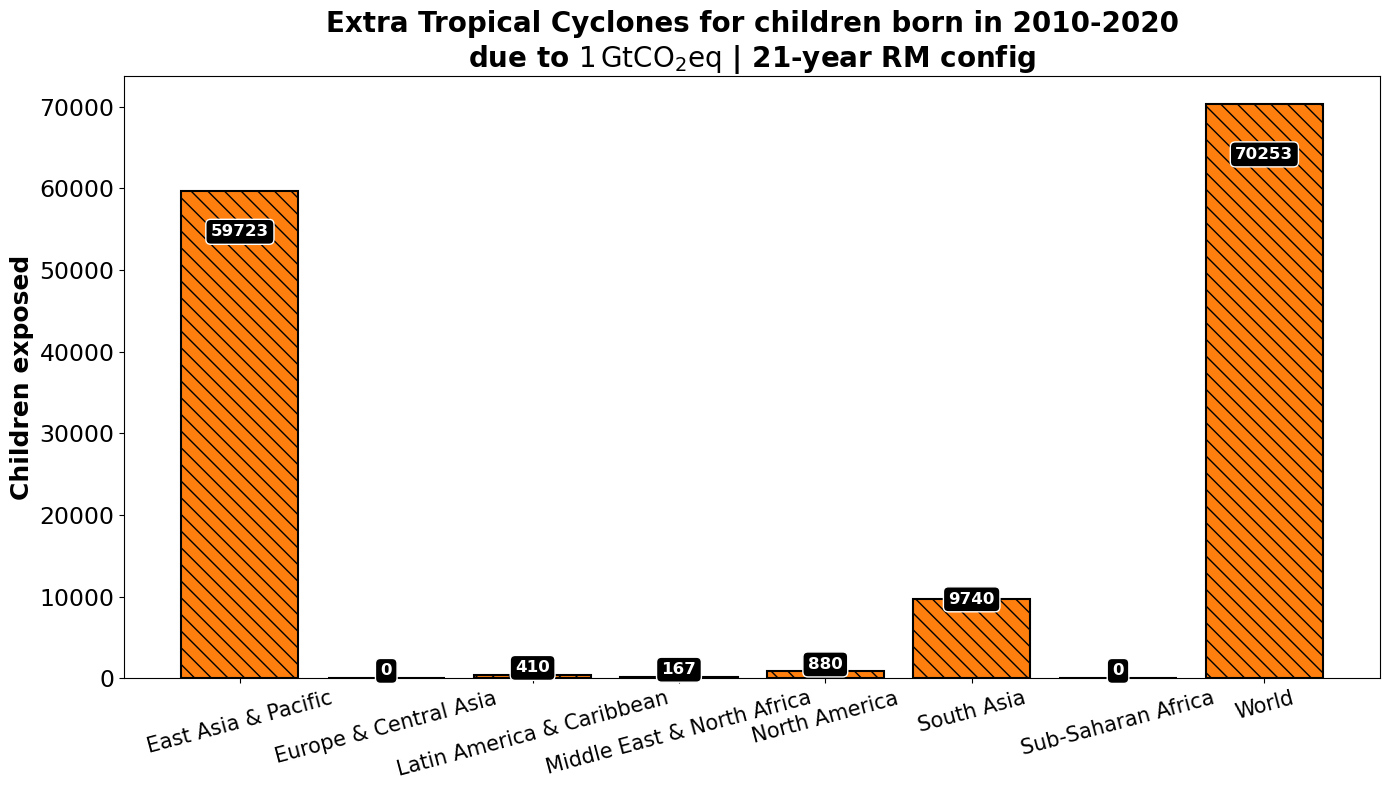

In [35]:
plt.close('all')

hazard_idx = 5  # Heat waves

hazard_name_str = hazards_name[hazard_idx]

valc_total_values = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(hazard=hazards[hazard_idx]).values
regions = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm.coords['region'].values

x_pos = np.arange(len(regions))

x_labels = [r.decode() if isinstance(r, bytes) else str(r) for r in regions]

fig, ax = plt.subplots(figsize=(14,8))

bars = ax.bar(x_pos, valc_total_values, color='tab:orange', hatch='\\\\', edgecolor='black', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=15, rotation=15)
ax.set_ylabel('Children exposed', fontsize=18, fontweight='bold')
ax.tick_params(axis='y', labelsize=17)

ax.set_title(f'Extra {hazard_name_str} for children born in 2010-2020\ndue to $1\,\mathrm{{GtCO}}_2\mathrm{{eq}}$ | 21-year RM config', 
             fontsize=20, fontweight='bold')

for rect, value in zip(bars, valc_total_values):
    if not np.isnan(value):
        ax.text(rect.get_x() + rect.get_width() / 2, value * 0.90, f'{int(np.round(value))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig2a_Reference_Pulse_{hazard_name_str}_regions_comp_rm_config_21.png', bbox_inches='tight', dpi=300)
plt.show()

##### B. 11 years Rolling Mean Configuration

In [23]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_Regions_gmt_{}_{}_config_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm','11'), 'rb') as f:
        ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm_config_11 = pk.load(f)

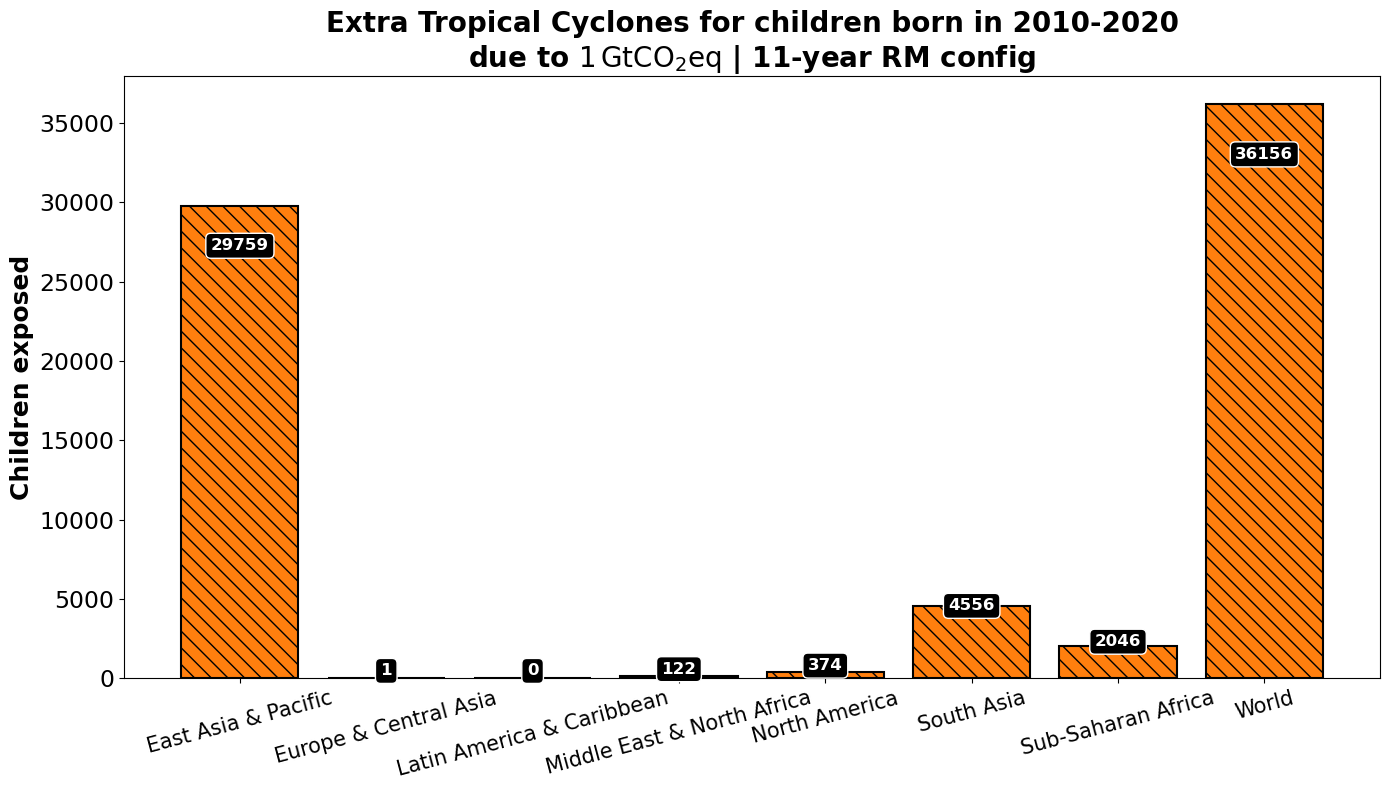

In [24]:
plt.close('all')

hazard_idx = 5  # Heat waves (ou l'indice correspondant selon ta liste)

hazard_name_str = hazards_name[hazard_idx]
hazard_name = hazards[hazard_idx]

# Get the values for the new dataset (config 11)
valc_total_values = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm_config_11['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(hazard=hazard_name).values
regions = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm_config_11.coords['region'].values

x_pos = np.arange(len(regions))
x_labels = [r.decode() if isinstance(r, bytes) else str(r) for r in regions]

fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.bar(x_pos, valc_total_values, color='tab:orange', hatch='\\\\', edgecolor='black', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=15, rotation=15)
ax.set_ylabel('Children exposed', fontsize=18, fontweight='bold')
ax.tick_params(axis='y', labelsize=17)

ax.set_title(f'Extra {hazard_name_str} for children born in 2010-2020\n'
             f'due to $1\,\mathrm{{GtCO}}_2\mathrm{{eq}}$ | 11-year RM config', 
             fontsize=20, fontweight='bold')

for rect, value in zip(bars, valc_total_values):
    if not np.isnan(value):
        ax.text(rect.get_x() + rect.get_width() / 2, value * 0.90, f'{int(np.round(value))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig2b_Reference_Pulse_{hazard_name_str}_regions_comp_rm_config_11.png', bbox_inches='tight', dpi=300)
plt.show()


#### Slopes of exposure per region

##### 1. For the Grant et al.(2025) Rolling Mean Configuration

In [25]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_Regions_gmt_{}_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm'), 'rb') as f:
        ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm = pk.load(f)

#print(ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_slope_exposure'].sel(region='East Asia & Pacific'))

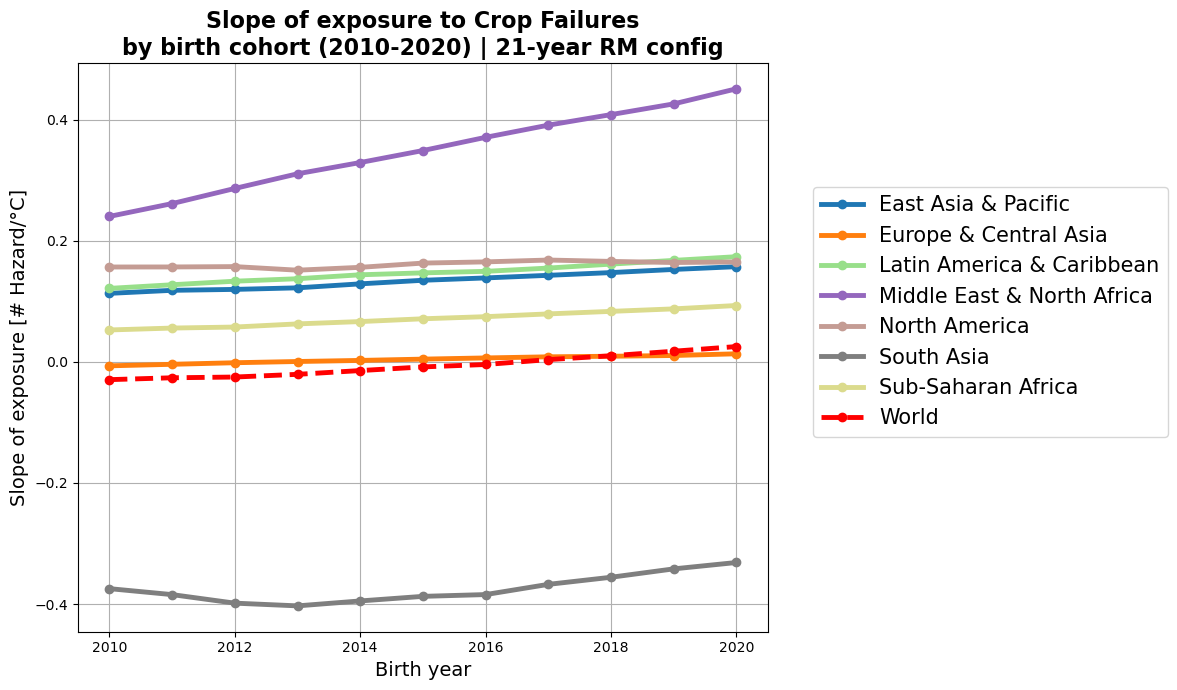

In [26]:
import matplotlib.cm as cm

# Select the hazard of interest

hazard_idx = 1  

hazard_name_str = hazards_name[hazard_idx]
hazard_name = hazards[hazard_idx]

ds_sel = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_slope_exposure'].sel(hazard=hazard_name)

# Select the birth years of interest
birth_years = np.arange(2010, 2021)
ds_sel = ds_sel.sel(birth_year=birth_years)

# Prepare colors using a qualitative colormap (tab20 has 20 distinct colors)
cmap = cm.get_cmap('tab20', len(ds_sel.region.values))

plt.figure(figsize=(12, 7))

# Loop over regions to plot each one with its own color
for i, region in enumerate(ds_sel.region.values):
    slope_values = ds_sel.sel(region=region).values
    if region == 'World':
        plt.plot(birth_years, slope_values, marker='o', lw=3.5, label=region, color='red', linestyle='--')
    else:
        plt.plot(birth_years, slope_values, marker='o', lw=3.5, label=region, color=cmap(i))

# Customize the plot aesthetics
plt.title(f"Slope of exposure to {hazard_name_str}\nby birth cohort (2010-2020) | 21-year RM config", fontsize=16, fontweight='bold')
plt.xlabel("Birth year", fontsize=14)
plt.ylabel("Slope of exposure [# Hazard/°C]", fontsize=14)
plt.grid(True)
plt.legend(fontsize=15, bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.tight_layout()
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig3_Reference_Pulse_{hazard_name_str}_regions_slope_comp.png', bbox_inches='tight', dpi=300)
plt.show()

##### 2. For the 11 years Rolling Mean Configuration

In [27]:
# Load the values computed by the Source2Suffering framework with the new demography but with the 11-years rolling mean configuration #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_Regions_gmt_{}_{}_config_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm','11'), 'rb') as f:
        ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm_config_11 = pk.load(f)

#print(ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_slope_exposure'].sel(region='East Asia & Pacific'))

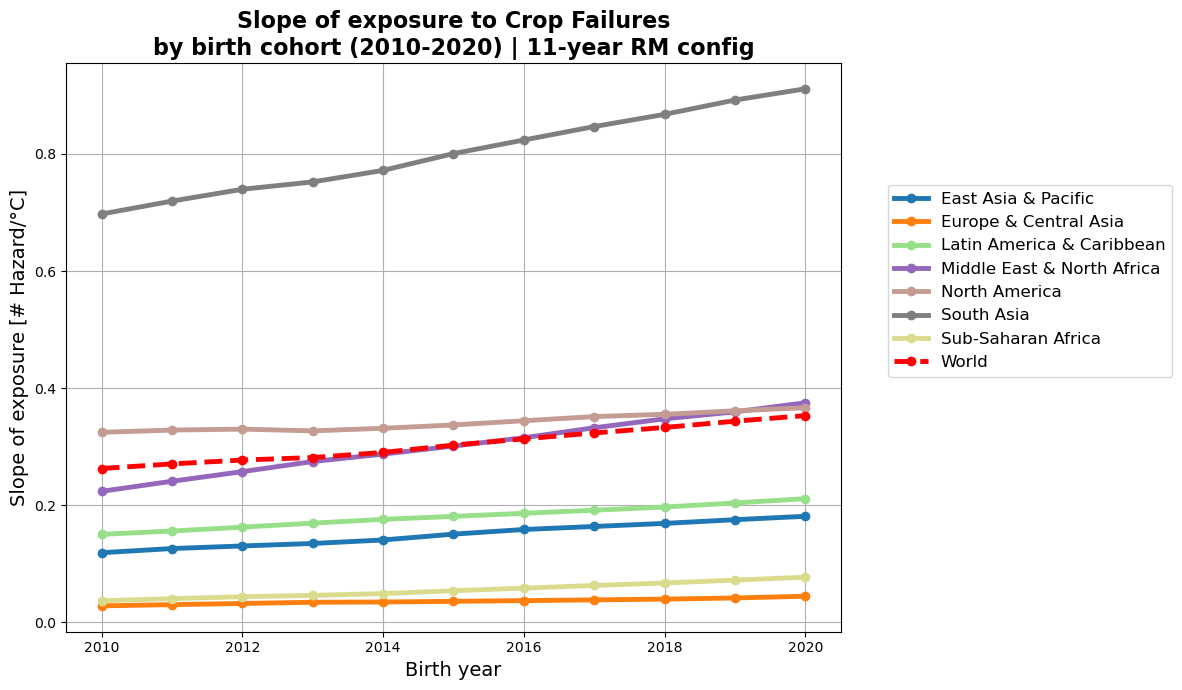

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Select the hazard of interest
hazard_idx = 1  

hazard_name_str = hazards_name[hazard_idx]
hazard_name = hazards[hazard_idx]

# Select the corresponding DataArray for the chosen hazard
ds_sel = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm_config_11['valc_slope_exposure'].sel(hazard=hazard_name)

# Select the birth years of interest
birth_years = np.arange(2010, 2021)
ds_sel = ds_sel.sel(birth_year=birth_years)

# Prepare colors using a qualitative colormap (tab20 has 20 distinct colors)
cmap = cm.get_cmap('tab20', len(ds_sel.region.values))

plt.figure(figsize=(12, 7))

# Loop over regions to plot each one with its own color
for i, region in enumerate(ds_sel.region.values):
    slope_values = ds_sel.sel(region=region).values
    if region == 'World':
        plt.plot(birth_years, slope_values, marker='o', lw=3.5, label=region, color='red', linestyle='--')
    else:
        plt.plot(birth_years, slope_values, marker='o', lw=3.5, label=region, color=cmap(i))

# Customize the plot aesthetics
plt.title(f"Slope of exposure to {hazard_name_str}\nby birth cohort (2010-2020) | 11-year RM config", fontsize=16, fontweight='bold')
plt.xlabel("Birth year", fontsize=14)
plt.ylabel("Slope of exposure [# Hazard/°C]", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.tight_layout()

# Save figure
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig3_Reference_Pulse_{hazard_name_str}_regions_slope_comp_rm_config_11.png', bbox_inches='tight', dpi=300)
plt.show()


### 2.2 Spatialization at the country level

#### Total number of people exposed per region

##### A. 21 years Rolling Mean Configuration

In [38]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_Countries_gmt_{}_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm'), 'rb') as f:
        ds_S2S_Reference_Pulse_Countries_gmt_ar6_new_rm = pk.load(f)

print(ds_S2S_Reference_Pulse_Countries_gmt_ar6_new_rm)

<xarray.Dataset>
Dimensions:                                                         (hazard: 6,
                                                                     birth_year: 22,
                                                                     country: 177)
Coordinates:
  * hazard                                                          (hazard) <U20 ...
  * birth_year                                                      (birth_year) int64 ...
  * country                                                         (country) object ...
Data variables:
    valc_nr_children_facing_extra_hazard_Reference_Pulse            (country, hazard, birth_year) float64 ...
    valc_nr_children_facing_extra_hazard_Reference_Pulse_ref        (country, hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse      (country, hazard) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref  (country, hazard) float64 ...
    valc_slope_exposure 

Selection for 10 countries in differents regions 

/tmp/ipykernel_3719224/3649987841.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=color, hatch='//', edgecolor='black') for color in tab_colors]


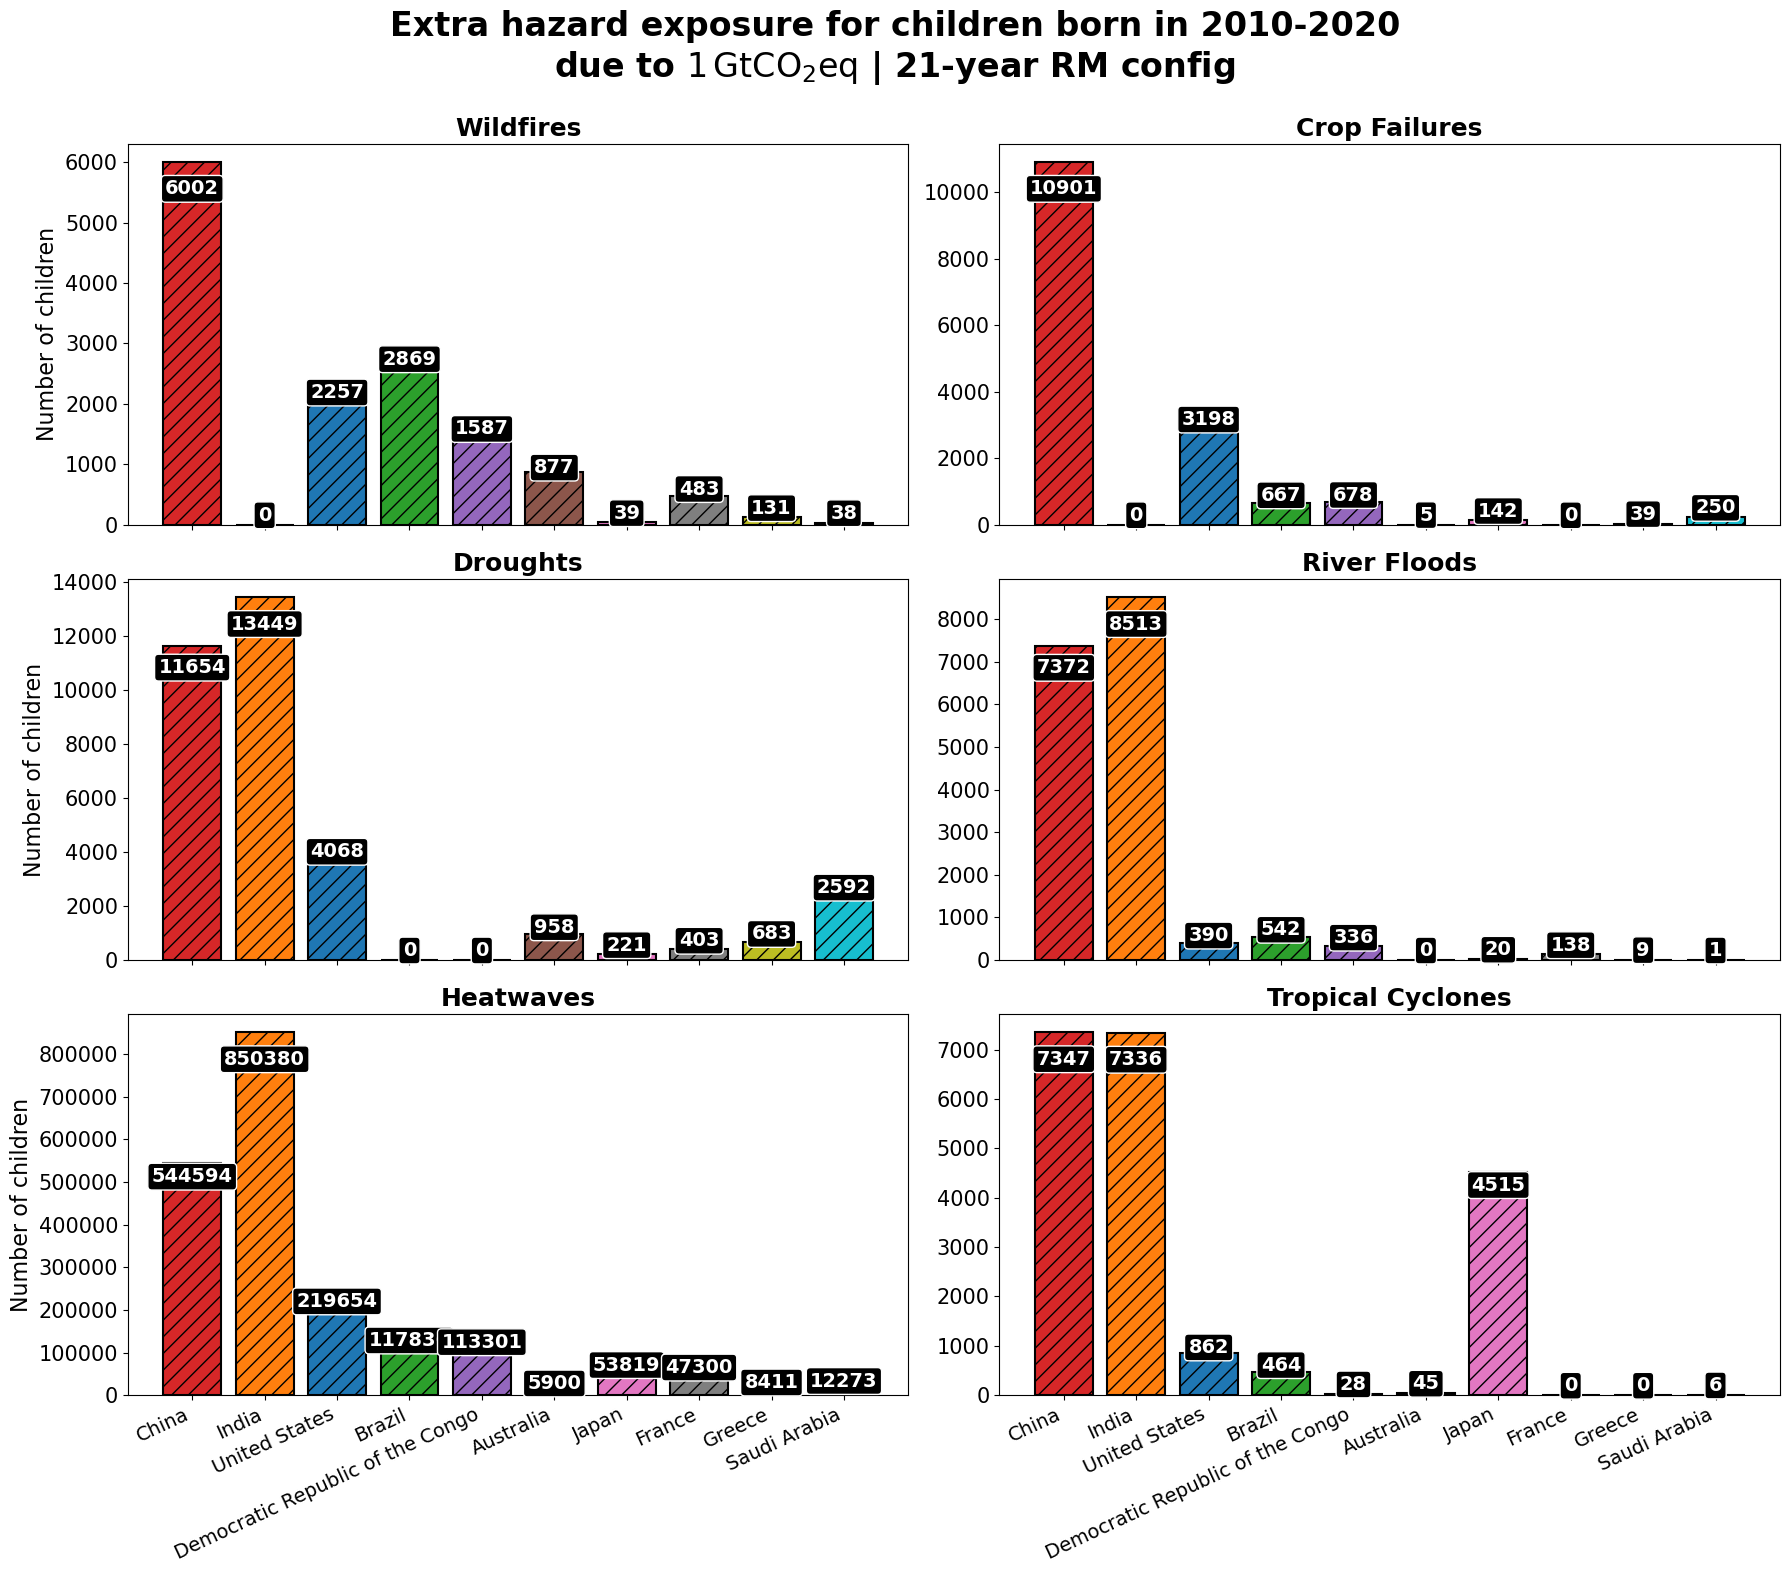

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# List of countries to display
countries_list = [
    'China',
    'India',
    'United States',
    'Brazil',
    'Democratic Republic of the Congo',
    'Australia',
    'Japan',
    'France',
    'Greece',
    'Saudi Arabia',
]

# Define a list of tab colors
tab_colors = [
    'tab:red', 'tab:orange', 'tab:blue', 'tab:green', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

plt.close('all')

fig, axes = plt.subplots(3, 2, figsize=(18, 16), sharex='col')  # Share x-axis by column
axes = axes.flatten()

x_pos = np.arange(len(countries_list))

# Iterate over the six hazards
for hazard_idx in range(6):

    ax = axes[hazard_idx]
    
    hazard_name_str = hazards_name[hazard_idx]
    
    # Extract values for all countries for this hazard
    valc_total_values = []
    for country in countries_list:
        value = ds_S2S_Reference_Pulse_Countries_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
            hazard=hazards[hazard_idx],
            country=country
        ).values.item()
        valc_total_values.append(value)
    
    # Plot bars with individual colors and hatching
    bars = []
    for xpos, value, color in zip(x_pos, valc_total_values, tab_colors):
        bar = ax.bar(xpos, value, color=color, hatch='//', edgecolor='black', linewidth=1.5)
        bars.append(bar)
    
    # Only add x-axis labels for the bottom plots (last row)
    if hazard_idx in [4, 5]:  # indices of the last row in 3x2 grid
        ax.set_xticks(x_pos)
        ax.set_xticklabels(countries_list, fontsize=14, rotation=25, ha='right')
    else:
        ax.set_xticks(x_pos)
        ax.set_xticklabels([''] * len(countries_list))  # Empty labels for upper plots
    
    # Add y-axis label only for plots in the left column (even indices)
    if hazard_idx % 2 == 0:
        ax.set_ylabel('Number of children', fontsize=16)
    
    ax.tick_params(axis='y', labelsize=15)
    
    ax.set_title(hazard_name_str, fontsize=18, fontweight='bold')
    
    # Add value labels on top of each bar
    for xpos, value in zip(x_pos, valc_total_values):
        if not np.isnan(value):
            ax.text(xpos, value * 0.90, f'{int(np.round(value))}',
                    ha='center', va='bottom', fontsize=14, fontweight='bold', color='white',
                    bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.2'))

# General title for the whole figure
fig.suptitle('Extra hazard exposure for children born in 2010-2020\n'
             'due to $1\,\mathrm{GtCO}_2\mathrm{eq}$ | 21-year RM config', 
             fontsize=24, fontweight='bold')

# Add a legend for the colors
handles = [plt.Rectangle((0,0),1,1, color=color, hatch='//', edgecolor='black') for color in tab_colors]

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for title and legend
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig4a_Reference_Pulse_countries_rm_config_21.png', bbox_inches='tight', dpi=300)
plt.show()


Selection of countries among the same region

North America

/tmp/ipykernel_3719224/3377894121.py:78: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color, hatch='//', edgecolor='black') for color in tab_colors]


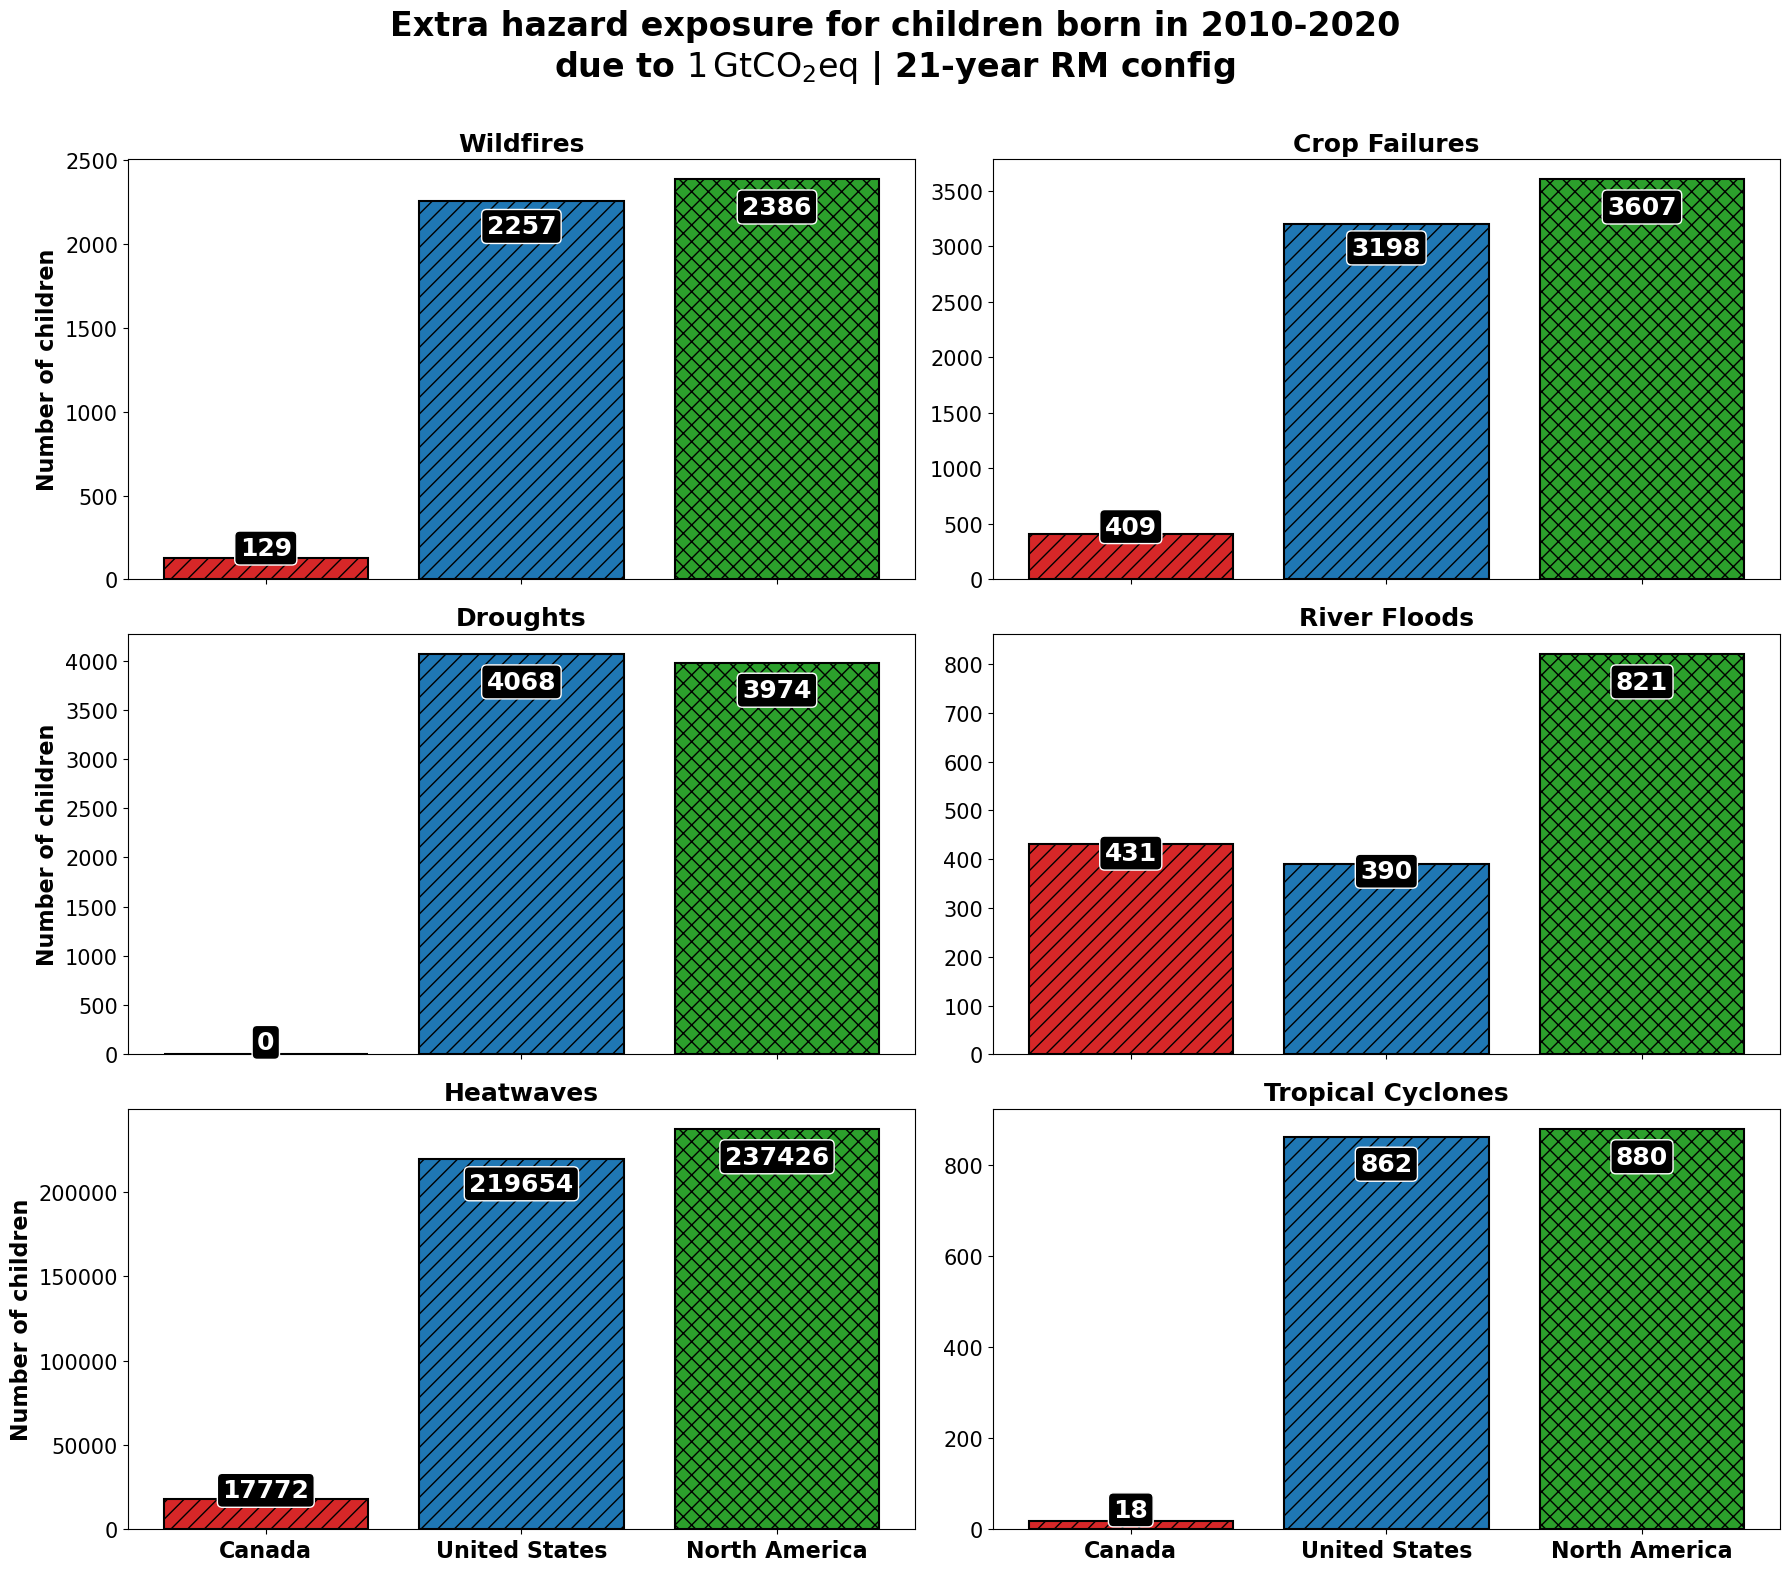

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# List of entities to display
entities_list = ['Canada', 'United States', 'North America']

# Define a list of tab colors
tab_colors = ['tab:red', 'tab:blue', 'tab:green']

plt.close('all')

fig, axes = plt.subplots(3, 2, figsize=(18, 16), sharex='col')
axes = axes.flatten()

x_pos = np.arange(len(entities_list))

# Iterate over the six hazards
for hazard_idx in range(6):

    ax = axes[hazard_idx]
    
    hazard_name_str = hazards_name[hazard_idx]
    
    # Extract values for the two countries
    valc_total_values = []
    
    for country in ['Canada', 'United States']:
        value = ds_S2S_Reference_Pulse_Countries_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
            hazard=hazards[hazard_idx],
            country=country
        ).values.item()
        valc_total_values.append(value)
    
    # Extract value for the region 'North America'
    region_value = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
        hazard=hazards[hazard_idx],
        region='North America'
    ).values.item()
    
    valc_total_values.append(region_value)
    
    # Plot bars with individual colors and hatching
    for xpos, value, color, entity in zip(x_pos, valc_total_values, tab_colors, entities_list):
        if entity == 'North America':
            hatch_style = 'xx'  # Different hatch for the region
        else:
            hatch_style = '//'
        ax.bar(xpos, value, color=color, hatch=hatch_style, edgecolor='black', linewidth=1.5)
    
    # Only add x-axis labels for the bottom plots (last row)
    if hazard_idx in [4, 5]:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(entities_list, fontsize=16, fontweight="bold")
    else:
        ax.set_xticks(x_pos)
        ax.set_xticklabels([''] * len(entities_list))
    
    # Add y-axis label only for plots in the left column (even indices)
    if hazard_idx % 2 == 0:
        ax.set_ylabel('Number of children', fontsize=16, fontweight="bold")
    
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(hazard_name_str, fontsize=18, fontweight='bold')
    
    # Add value labels on top of each bar
    for xpos, value in zip(x_pos, valc_total_values):
        if not np.isnan(value):
            ax.text(xpos, value * 0.90, f'{int(np.round(value))}',
                    ha='center', va='bottom', fontsize=18, fontweight='bold', color='white',
                    bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.2'))

# General title for the whole figure
fig.suptitle('Extra hazard exposure for children born in 2010-2020\n'
             'due to $1\,\mathrm{GtCO}_2\mathrm{eq}$ | 21-year RM config',
             fontsize=24, fontweight='bold')

# Add a legend for the colors
handles = [plt.Rectangle((0, 0), 1, 1, color=color, hatch='//', edgecolor='black') for color in tab_colors]
labels = entities_list

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig5a_Reference_Pulse_Region&Countries_rm_config_21.png', bbox_inches='tight', dpi=300)
plt.show()


Middle East & North Africa

In [94]:
with open(data_dir + '{}/country/ds_regions.pkl'.format('pickles_S2S_v1'), 'rb') as f:
            ds_regions=pk.load(f)  

In [97]:
region_idx = 6
list_member_countries_select_region = ds_regions['member_countries'].sel(region=region_idx)
print(list_member_countries_select_region)

<xarray.DataArray 'member_countries' ()>
array(list(['United Arab Emirates', 'Djibouti', 'Algeria', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Oman', 'Qatar', 'Saudi Arabia', 'Syria', 'Tunisia', 'Yemen']),
      dtype=object)
Coordinates:
    region   int64 6


/tmp/ipykernel_3719224/2212436486.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='gray', hatch='//', edgecolor='black', label='Countries'),
/tmp/ipykernel_3719224/2212436486.py:100: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='gray', hatch='', edgecolor='black', label=r'$\sum$'),
/tmp/ipykernel_3719224/2212436486.py:101: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='gray', hatch='xx', edgecolor='black', label='Region aggregate')


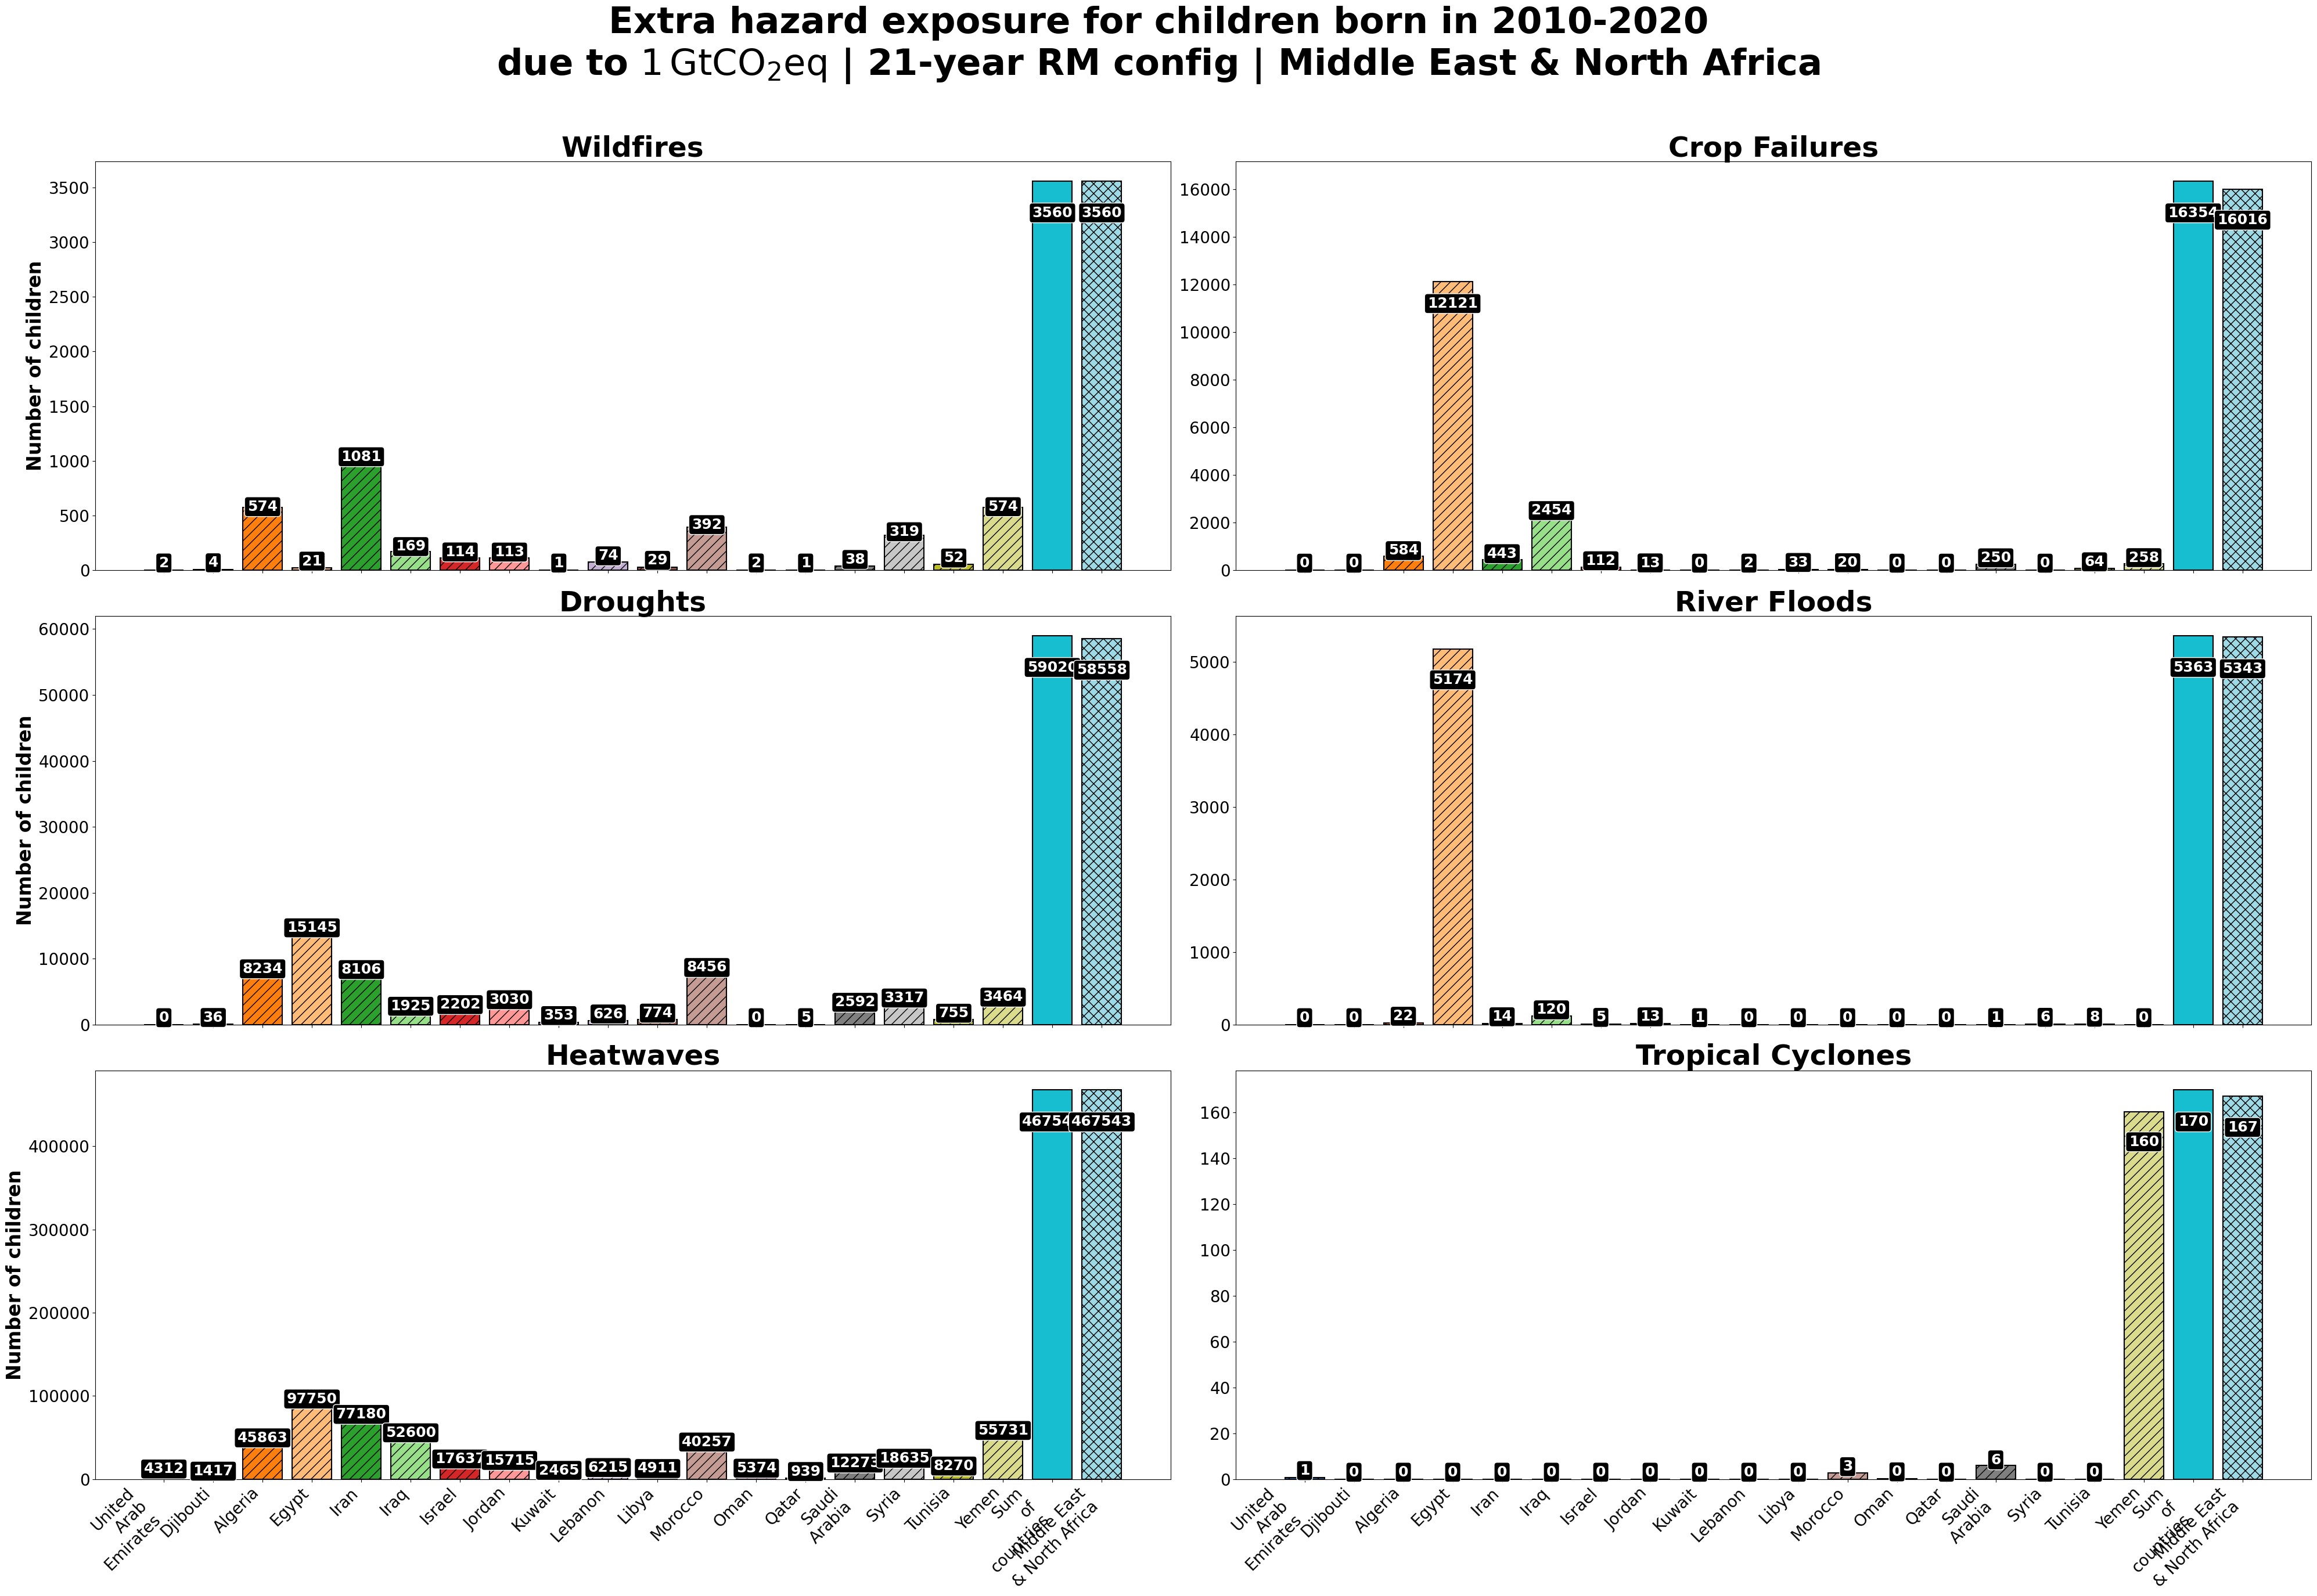

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Extract the list of countries for the region "Middle East & North Africa"
member_countries = list_member_countries_select_region.item()

# Prepare display names with line breaks for long names
entities_list_display = []
for country in member_countries:
    if ' ' in country:
        entities_list_display.append(country.replace(' ', '\n'))
    else:
        entities_list_display.append(country)

# Add "Sum of countries" and region name at the end for plotting
entities_list_display += ['Sum\nof\ncountries', 'Middle East\n& North Africa']

# Generate a colormap with enough distinct colors for all countries
n_colors = len(member_countries) + 2
cmap = cm.get_cmap('tab20', n_colors)
tab_colors = [mcolors.to_hex(cmap(i)) for i in range(n_colors)]

plt.close('all')

# Larger figure size for better readability
fig, axes = plt.subplots(3, 2, figsize=(40, 28), sharex='col')
axes = axes.flatten()

x_pos = np.arange(len(entities_list_display))

for hazard_idx in range(6):
    ax = axes[hazard_idx]
    hazard_name_str = hazards_name[hazard_idx]

    valc_total_values = []

    # Extract values for all member countries
    for country in member_countries:
        value = ds_S2S_Reference_Pulse_Countries_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
            hazard=hazards[hazard_idx],
            country=country
        ).values.item()
        valc_total_values.append(value)

    # Compute sum of countries
    sum_of_countries = np.nansum(valc_total_values)
    valc_total_values.append(sum_of_countries)

    # Extract value for the region itself
    region_value = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
        hazard=hazards[hazard_idx],
        region='Middle East & North Africa'
    ).values.item()
    valc_total_values.append(region_value)

    # Plot bars with individual colors and hatching
    for xpos, value, color, entity in zip(x_pos, valc_total_values, tab_colors, entities_list_display):
        if entity == 'Middle East\n& North Africa':
            hatch_style = 'xx'
        elif entity == 'Sum\nof\ncountries':
            hatch_style = ''
        else:
            hatch_style = '//'
        ax.bar(xpos, value, color=color, hatch=hatch_style, edgecolor='black', linewidth=1.5)

    # X-axis labels
    ax.set_xticks(x_pos)
    if hazard_idx in [4, 5]:
        ax.set_xticklabels(entities_list_display, fontsize=20, ha='right', rotation=45)
    else:
        ax.set_xticklabels([''] * len(entities_list_display))

    # Y-axis settings
    ax.tick_params(axis='y', labelsize=20)
    if hazard_idx % 2 == 0:
        ax.set_ylabel('Number of children', fontsize=24, fontweight="bold")

    # Subplot title
    ax.set_title(hazard_name_str, fontsize=35, fontweight='bold')

    # Value labels on top of each bar
    for xpos, value in zip(x_pos, valc_total_values):
        if not np.isnan(value):
            ax.text(xpos, value * 0.90, f'{int(np.round(value))}',
                    ha='center', va='bottom', fontsize=18, fontweight='bold', color='white',
                    bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.2'))

    

# General title for the whole figure
fig.suptitle('Extra hazard exposure for children born in 2010-2020\n'
             'due to $1\,\mathrm{GtCO}_2\mathrm{eq}$ | 21-year RM config | Middle East & North Africa',
             fontsize=45, fontweight='bold')

# Legend for the three types of bars
handles = [
    plt.Rectangle((0, 0), 1, 1, color='gray', hatch='//', edgecolor='black', label='Countries'),
    plt.Rectangle((0, 0), 1, 1, color='gray', hatch='', edgecolor='black', label=r'$\sum$'),
    plt.Rectangle((0, 0), 1, 1, color='gray', hatch='xx', edgecolor='black', label='Region aggregate')
]

# Adjust layout for larger figure and rotated labels
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig5b_Reference_Pulse_Region&Countries_rm_config_21.png', bbox_inches='tight', dpi=300)
plt.show()


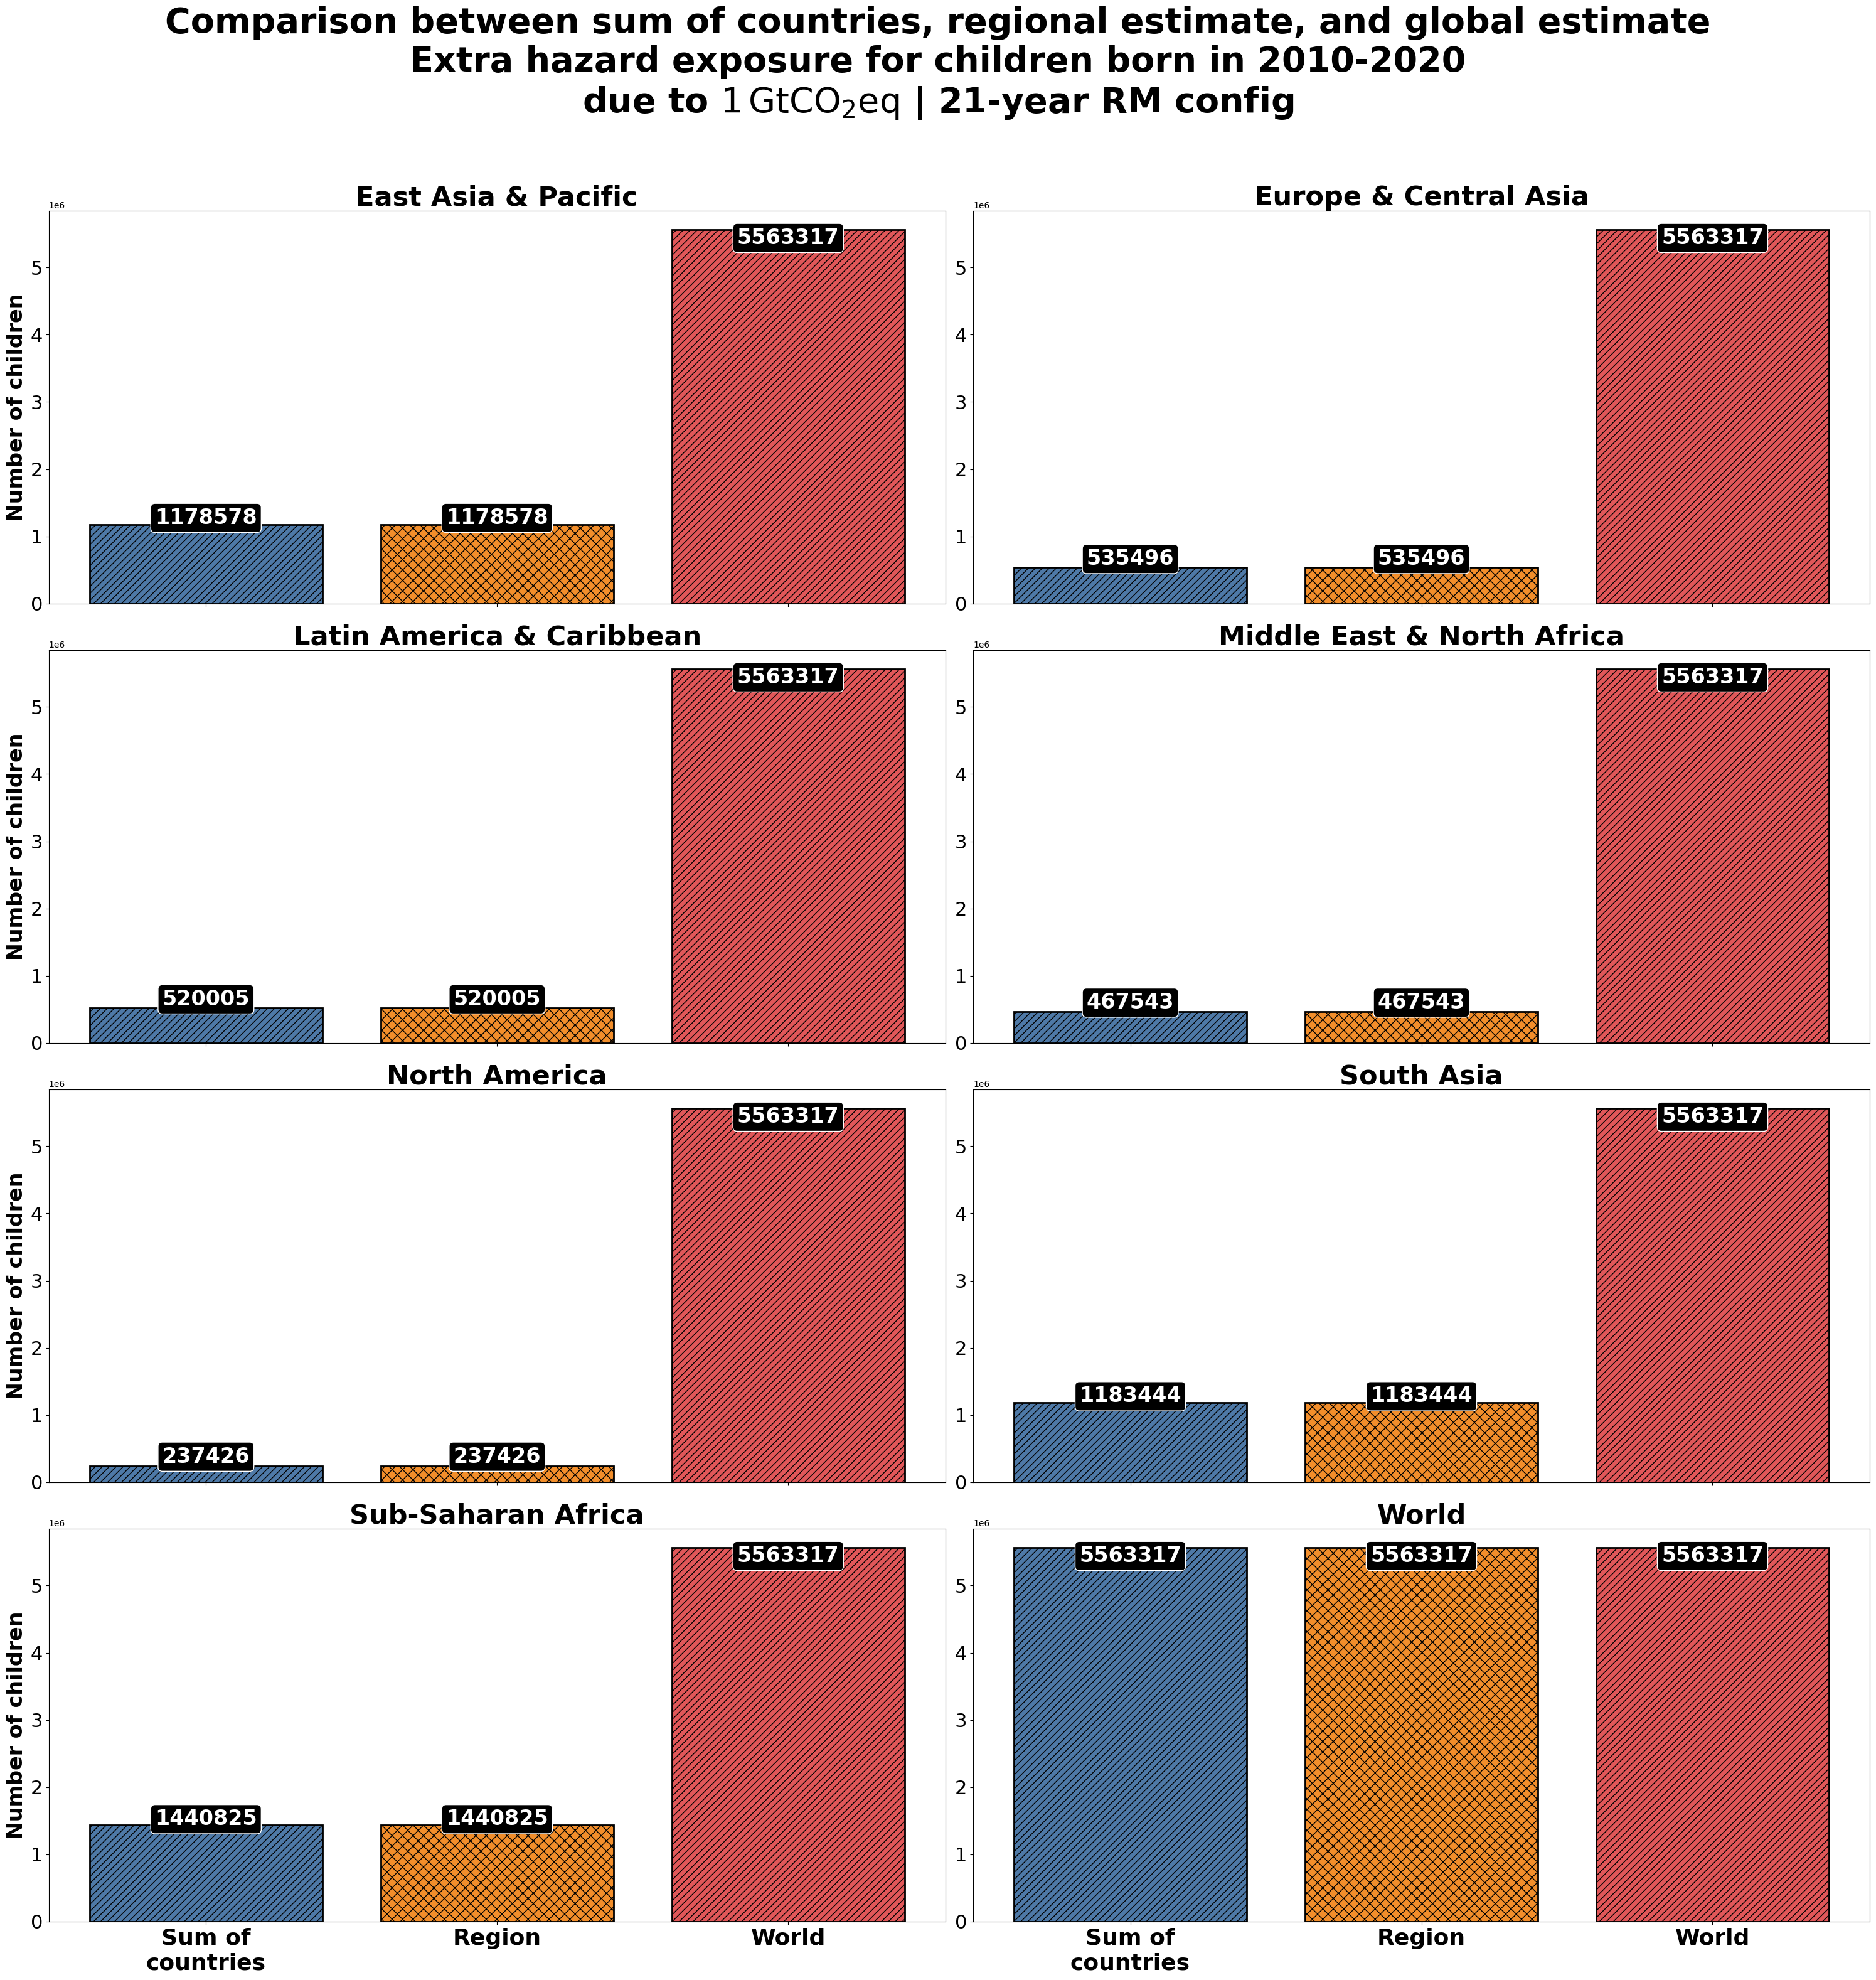

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Define the list of regions of interest (8 regions → 8 subplots)
region_int_ind = [0, 1, 3, 6, 7, 8, 9, 11]

# Select prettier colors manually from 'tab10' or 'tab20'
bar_colors = ['#4E79A7', '#F28E2B', '#E15759']  # blue, orange, red

plt.close('all')

# Create 8 subplots → 4 rows x 2 columns
fig, axes = plt.subplots(4, 2, figsize=(30, 35))
axes = axes.flatten()

for idx, region_idx in enumerate(region_int_ind):
    ax = axes[idx]

    region_name = ds_regions['name'].sel(region=region_idx).values
    list_member_countries_select_region = ds_regions['member_countries'].sel(region=region_idx)
    member_countries = list_member_countries_select_region.item()

    valc_countries = []
    for country in member_countries:
        value = ds_S2S_Reference_Pulse_Countries_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
            hazard='heatwavedarea',
            country=country
        ).values.item()
        valc_countries.append(value)

    sum_of_countries = np.nansum(valc_countries)

    region_value = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
        hazard='heatwavedarea',
        region=region_name
    ).values.item()

    world_value = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(
        hazard='heatwavedarea',
        region='World'
    ).values.item()

    # Bar plot positions for 3 bars
    x_pos = np.array([0, 1, 2])
    bar_labels = ['Sum of\ncountries', 'Region', 'World']
    heights = [sum_of_countries, region_value, world_value]

    hatch_styles = ['///', 'xx', '///']

    for xpos, height, color, hatch in zip(x_pos, heights, bar_colors, hatch_styles):
        ax.bar(xpos, height, color=color, hatch=hatch, edgecolor='black', linewidth=2.0)

    ax.set_xticks(x_pos)
    
    # Set xticklabels only for last row
    if idx in [6, 7]:  # Last row of subplots (indices 6 and 7)
        ax.set_xticklabels(bar_labels, fontsize=26, fontweight='bold')
    else:
        ax.set_xticklabels([])

    ax.tick_params(axis='y', labelsize=22)

    # Set y-label only for left column (even indices: 0, 2, 4, 6)
    if idx % 2 == 0:
        ax.set_ylabel('Number of children', fontsize=24, fontweight="bold")

    ax.set_title(region_name, fontsize=31, fontweight='bold')

    for xpos, value in zip(x_pos, heights):
        if not np.isnan(value):
            ax.text(xpos, value * 0.95, f'{int(np.round(value))}',
                    ha='center', va='bottom', fontsize=24, fontweight='bold', color='white',
                    bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.2'))

# General title for the whole figure
fig.suptitle('Comparison between sum of countries, regional estimate, and global estimate\n'
             'Extra hazard exposure for children born in 2010-2020\n'
             'due to $1\,\mathrm{GtCO}_2\mathrm{eq}$ | 21-year RM config',
             fontsize=40, fontweight='bold')

plt.tight_layout(rect=[0, 0.08, 1, 0.96])
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig5c_Reference_Pulse_Region&Countries_rm_config_21.png', bbox_inches='tight', dpi=300)
plt.show()


## 3. Monte Carlo Sampling

### 3.1 Definition of PDFs

#### 3.1.1 Definition of Standardised PDFs 

##### Normal Distribution for Emissions

Based on an arbitrary value for std_dev

In [29]:
# Load the normal distribution created for the emissions # 

with open(data_dir+'{}/source2suffering/pdf/emissions/pdf_emissions_norm_test.pkl'.format('pickles_S2S_v1'), 'rb') as f:
        pdf_emissions = pk.load(f)

print(pdf_emissions)

<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x14e17b93b670>>


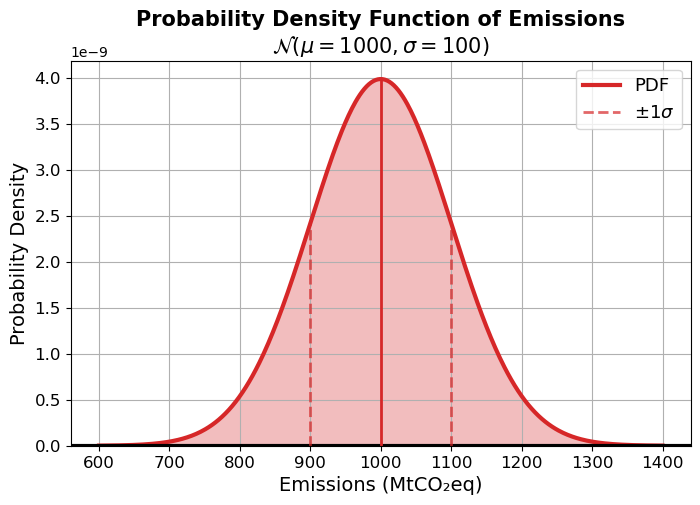

In [30]:
import numpy as np
import matplotlib.pyplot as plt

emissions_best_estimate = 1000e6
emissions_std_dev = 100e6

# ---------------------- Plot the PDF ---------------------- #
x = np.linspace(emissions_best_estimate - 4 * emissions_std_dev,
                emissions_best_estimate + 4 * emissions_std_dev, 500)
y = pdf_emissions(x)

x_mtco2eq = x / 1e6  # Convert to MtCO2eq for display

mu = emissions_best_estimate / 1e6
sigma = emissions_std_dev / 1e6

# Fonction pour récupérer la valeur PDF la plus proche
def get_pdf_value(x_val):
    idx = (np.abs(x_mtco2eq - x_val)).argmin()
    return y[idx]

y_mu = get_pdf_value(mu)
y_mu_minus_sigma = get_pdf_value(mu - sigma)
y_mu_plus_sigma = get_pdf_value(mu + sigma)

plt.figure(figsize=(8, 5))
plt.plot(
    x_mtco2eq,
    y,
    color='tab:red',
    label='PDF',
    lw=3
)

plt.fill_between(x_mtco2eq, y, color='tab:red', alpha=0.3)
plt.axhline(0, color='black', lw=3)

# Barres verticales partielles
plt.plot([mu, mu], [0, y_mu], color='tab:red', lw=2, linestyle='-')               # moyenne
plt.plot([mu - sigma, mu - sigma], [0, y_mu_minus_sigma], color='tab:red', lw=2, linestyle='--', alpha=0.7, label=r'$\pm 1 \sigma$')  # moyenne - 1σ
plt.plot([mu + sigma, mu + sigma], [0, y_mu_plus_sigma], color='tab:red', lw=2, linestyle='--', alpha=0.7)  # moyenne + 1σ

plt.xlabel('Emissions (MtCO₂eq)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)

plt.title(
    'Probability Density Function of Emissions\n'
    r'$\mathcal{N}(\mu=%.0f, \sigma=%.0f)$' % (mu, sigma),
    fontweight='bold',
    fontsize=15,
    loc='center'
)

# Ticks normaux, tick size augmenté
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(bottom=0)
plt.legend(fontsize=13)
plt.grid(True)

plt.savefig(scripts_dir + '/figures/source2suffering/pdf/fig1_stand_norm_pdf_emissions.png', bbox_inches='tight', dpi=300)
plt.show()


##### Normal Distribution for Emissions

Based on the assumption of a Normal distribution but use the best estimate and the std_dev from IPCC AR6

In [31]:
# Load the normal distribution created for the TCRE # 

with open(data_dir+'{}/source2suffering/pdf/tcre/pdf_tcre_norm_test.pkl'.format('pickles_S2S_v1'), 'rb') as f:
        pdf_tcre = pk.load(f)

print(pdf_tcre)

<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x14e17850b1f0>>


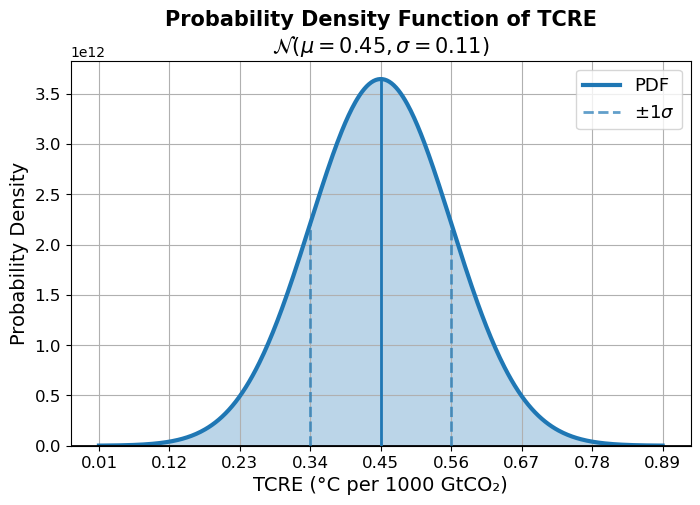

In [32]:
# Best estimate and standard deviation for TCRE (in °C per tonne CO₂)
tcre_best_estimate = 0.45 / 1e12  # °C per tonne CO₂ → correspond à 0.45 °C per 1000 GtCO₂
tcre_std_dev = 0.1094 / 1e12      # °C per tonne CO₂ → correspond à 0.1094 °C per 1000 GtCO₂

# Define the x-axis range: typically mean ± 4*std_dev
x = np.linspace(tcre_best_estimate - 4 * tcre_std_dev, tcre_best_estimate + 4 * tcre_std_dev, 500)

# Compute PDF values for these x
y = pdf_tcre(x)

# Conversion pour affichage en °C per 1000 GtCO₂
x_display = x * 1e12

# Positions moyenne et écart type en affichage
mu = 0.45
sigma = 0.1094

# Calculer les valeurs de PDF aux positions mu ± sigma
# Pour tracer la barre verticale partielle, on récupère le y correspondant à la position x verticale
def get_pdf_value(x_val):
    # Trouve l’indice dans x_display le plus proche de x_val
    idx = (np.abs(x_display - x_val)).argmin()
    return y[idx]

# Valeurs y aux positions mu et mu ± sigma
y_mu = get_pdf_value(mu)
y_mu_minus_sigma = get_pdf_value(mu - sigma)
y_mu_plus_sigma = get_pdf_value(mu + sigma)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    x_display,
    y,
    color='tab:blue',
    label=f'PDF',
    lw=3
)

# Remplissage sous la courbe
plt.fill_between(x_display, y, color='tab:blue', alpha=0.3)

# Ligne y=0
plt.axhline(0, color='black', lw=2)

# Barres verticales partielles (depuis y=0 jusqu'à la valeur du PDF)
plt.plot([mu, mu], [0, y_mu], color='tab:blue', lw=2, linestyle='-')               # moyenne
plt.plot([mu - sigma, mu - sigma], [0, y_mu_minus_sigma], color='tab:blue', lw=2, linestyle='--', alpha=0.7, label=r'$\pm 1 \sigma$')  # moyenne - 1σ
plt.plot([mu + sigma, mu + sigma], [0, y_mu_plus_sigma], color='tab:blue', lw=2, linestyle='--', alpha=0.7)  # moyenne + 1σ

plt.xlabel('TCRE (°C per 1000 GtCO₂)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title(
    'Probability Density Function of TCRE\n'
    r'$\mathcal{N}(\mu=%.2f, \sigma=%.2f)$' % (mu, sigma),
    fontweight='bold',
    fontsize=15,
    loc='center'
)
# Tick x centrés sur la moyenne, espacés d’un écart type
ticks = np.arange(mu - 4 * sigma, mu + 4 * sigma + 0.0001, sigma)
plt.xticks(ticks, [f"{tick:.2f}" for tick in ticks], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(bottom=-0.001)

plt.legend(fontsize=13)
plt.grid(True)
plt.savefig(scripts_dir + '/figures/source2suffering/pdf/fig1_stand_norm_pdf_tcre.png', bbox_inches='tight', dpi=300)

plt.show()


#### 2.1.2 Definition of Complex PDFs  